# Import module

In [21]:
import glob
import os.path
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import yasa

plt.style.use('default')
plt.rc('font', family='Arial')
plt.rc('axes', unicode_minus=False)

mne.set_log_level('CRITICAL')

# Import data and preprocessing

In [22]:
path_data = r'C:\Users\HP\PycharmProjects\as_monkey_eeg\X8_data'
files = glob.glob(os.path.join(path_data, '**', 'raw.edf'), recursive=True)

In [23]:
for file in files:
    raw = mne.io.read_raw_edf(file, verbose=False)

    sf = raw.info['sfreq']
    print(sf)

250.0
250.0
250.0
250.0
250.0
250.0
250.0
250.0
250.0


<Figure size 500x400 with 0 Axes>

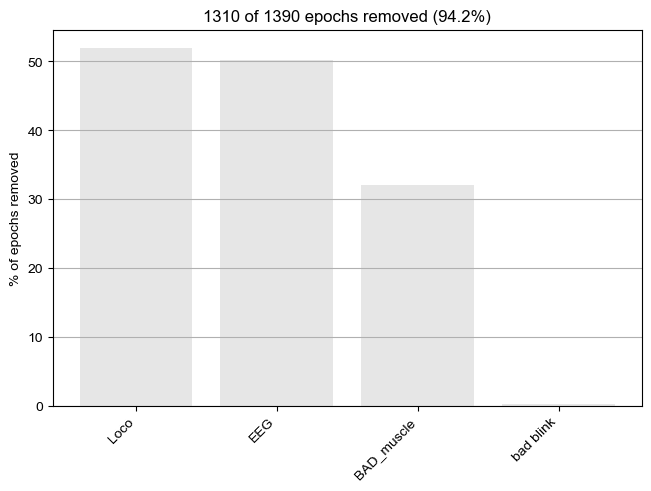

<Figure size 500x400 with 0 Axes>

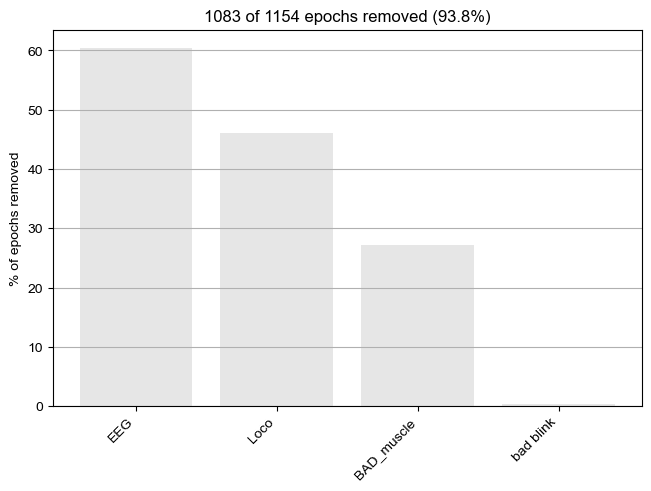

<Figure size 500x400 with 0 Axes>

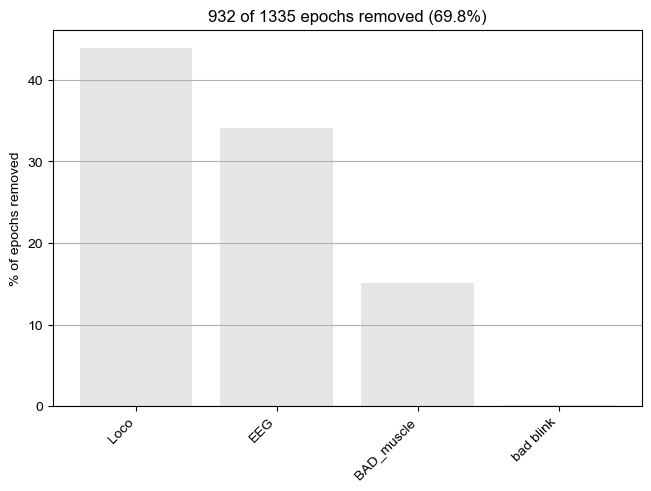

<Figure size 500x400 with 0 Axes>

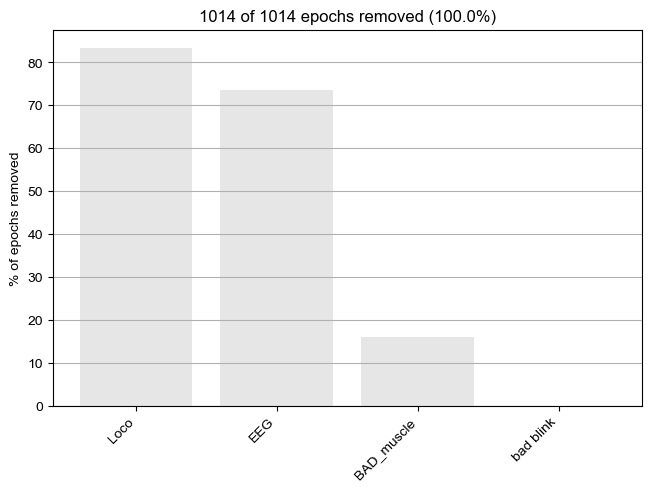

<Figure size 500x400 with 0 Axes>

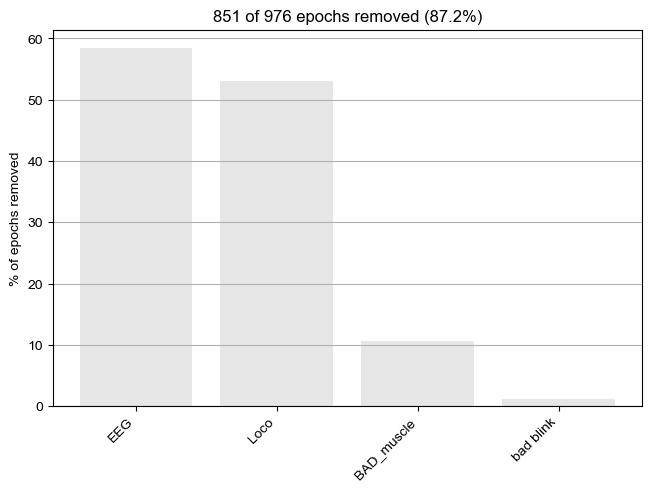

<Figure size 500x400 with 0 Axes>

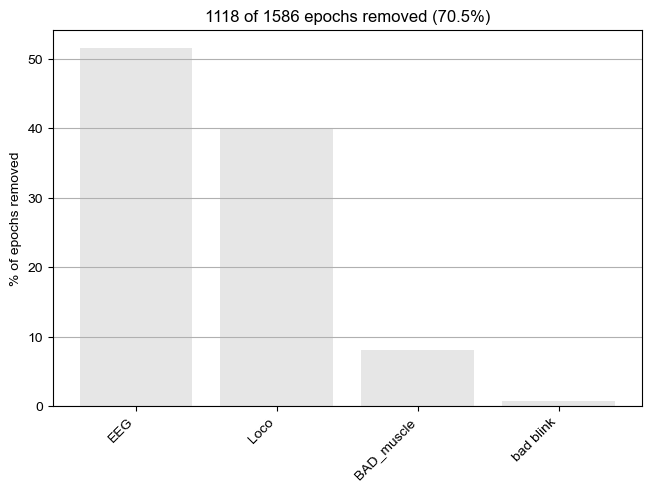

<Figure size 500x400 with 0 Axes>

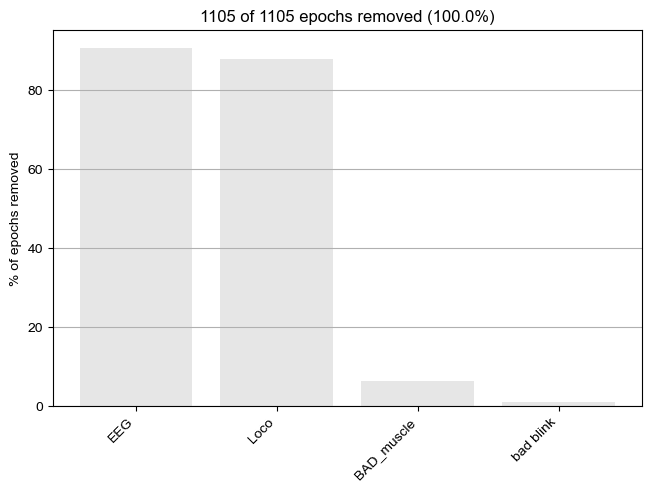

<Figure size 500x400 with 0 Axes>

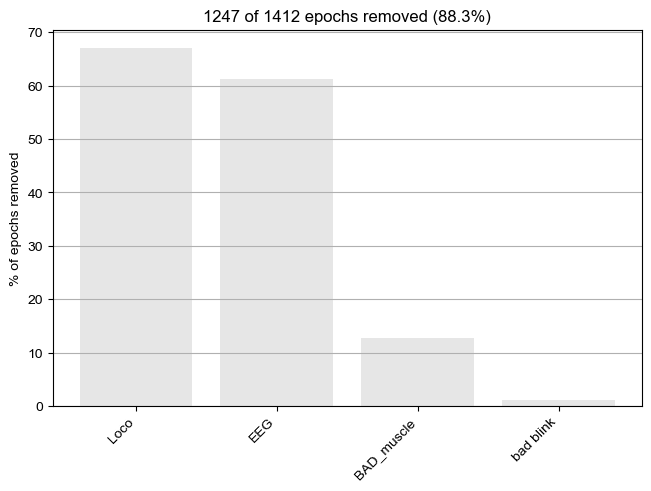

<Figure size 500x400 with 0 Axes>

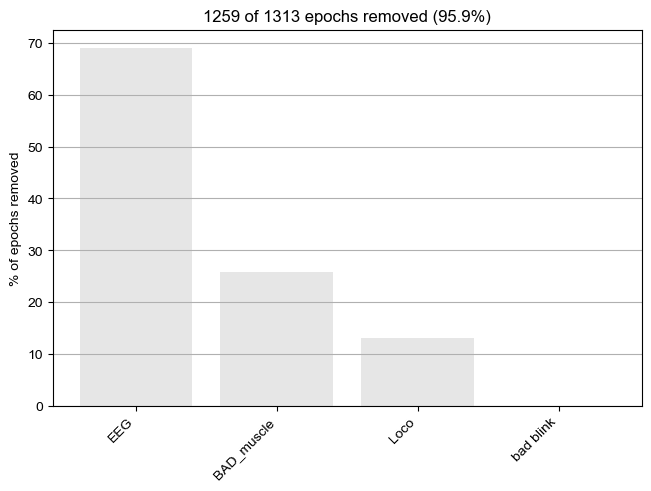

In [24]:
for file in files:
    animal, session = np.array(file.split('\\'))[[-3, -2]]
    raw = mne.io.read_raw_edf(file, preload=True, verbose=False)

    t = raw.times
    sf = raw.info['sfreq']

    seg_duration = 2  # seconds
    n_seg = np.floor(t.shape[0] / sf / seg_duration) - 1  # assert number of seg more than time

    raw.crop(0, seg_duration * n_seg, include_tmax=False)
    raw.set_channel_types({'Loco': 'bio'})
    raw.notch_filter(np.arange(50, 100, 50))

    eog_events = mne.preprocessing.find_eog_events(raw, ch_name='EEG')
    onsets = eog_events[:, 0] / raw.info["sfreq"] - 0.25
    durations = [0.5] * len(eog_events)
    descriptions = ["bad blink"] * len(eog_events)
    annot_blink = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )

    thr = 1.5
    annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
        raw,
        ch_type='eeg',
        threshold=thr,
        min_length_good=0.5,
        filter_freq=[110, 120],
    )

    raw.set_annotations(raw.annotations + annot_blink + annot_muscle)
    epochs = mne.make_fixed_length_epochs(raw.copy().filter(1, 40), duration=seg_duration, preload=True)
    epochs.drop_bad(flat=dict(eeg=5e-6), reject={'bio': 25e-6, 'eeg': 120e-6})

    ax = plt.figure(figsize=(5, 4))
    epochs.plot_drop_log(show=False)
    plt.show()

    raw_clean = raw.copy()
    raw_clean.filter(1, 40)
    data = raw_clean.get_data()

    data = data.reshape(2, len(epochs.drop_log), -1)

    flag = np.ones(len(epochs.drop_log), dtype='bool')
    flag[epochs.selection] = False
    data[0, flag, :] = np.nan
    data = data.reshape(2, -1)

    raw_clean._data = data

    raw_clean.save(os.path.join(path_data, raw.filenames[0].replace('.edf', '_clean.fif')), overwrite=True)

# Check data left

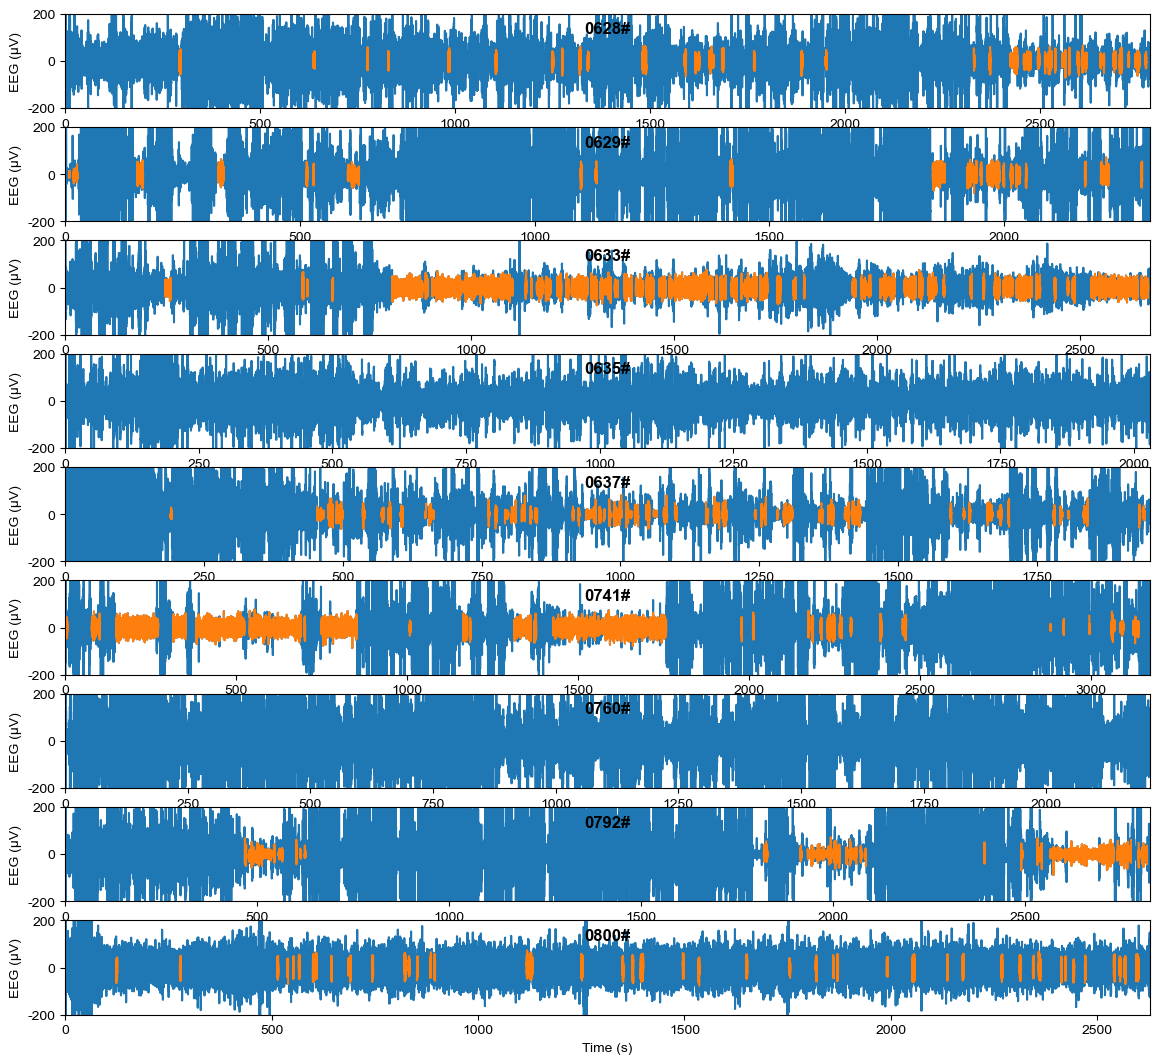

In [25]:
fig, ax_list = plt.subplots(len(files), 1, figsize=(14, 13))

for i, file in enumerate(files):
    animal, session = np.array(file.split('\\'))[[-3, -2]]
    
    raw = mne.io.read_raw_edf(file, preload=True)
    raw_clean = mne.io.read_raw_fif(os.path.join(path_data, raw.filenames[0].replace('.edf', '_clean.fif')))
    ax_list[i].plot(raw.times, raw.copy().filter(1, 40).pick([0]).get_data(units='uV').squeeze())
    ax_list[i].plot(raw_clean.times, raw_clean.copy().pick([0]).get_data(units='uV').squeeze())
    ax_list[i].set(
        ylabel='EEG (μV)',
        ylim=(-200, 200),
        xlim=(raw.times[[0, -1]])
    )
    
    ax_list[i].set_title(animal, fontdict={'fontweight': 'bold'},
                loc='center', y=0.7)

ax_list[-1].set_xlabel('Time (s)')  
plt.show()

# Plot

In [26]:
df_info = pd.read_excel(os.path.join(os.path.split(path_data)[0], 'info.xlsx'), index_col=0)

Data duration of 0628# in 2024-03-14 was 160.0 seconds
Data duration of 0629# in 2024-03-09 was 142.0 seconds
Data duration of 0633# in 2024-03-09 was 806.0 seconds
Data duration of 0635# in 2024-03-11 was 0.0 seconds
Data duration of 0637# in 2024-03-08 was 250.0 seconds
Data duration of 0741# in 2024-03-14 was 936.0 seconds
Data duration of 0760# in 2024-03-12 was 0.0 seconds
Data duration of 0792# in 2024-03-12 was 330.0 seconds
Data duration of 0800# in 2024-03-08 was 108.0 seconds


C:\Users\HP\AppData\Local\Temp\ipykernel_34696\3098192090.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(


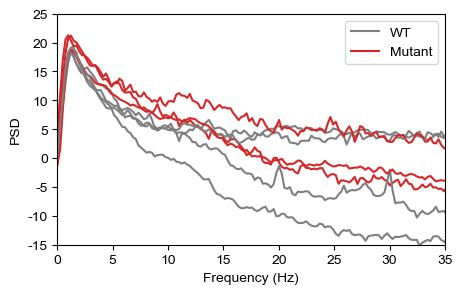

In [52]:
from scipy import signal

color_map = {
    'Mutant': 'tab:red', 
    'WT': 'tab:gray'
}

bands = [
    (1, 4, "Delta"),
    (4, 8, "Theta"),
    (8, 12, "Alpha"),
    (12, 30, "Beta"),
]

band_names = [band[-1] for band in bands]

df_bp = pd.DataFrame()

_, ax = plt.subplots(figsize=(5, 3))

l = {}

for i, file in enumerate(files):
    animal, session = np.array(file.split('\\'))[[-3, -2]]
    
    color = color_map[df_info.loc[animal, 'Genotype']]
    
    raw = mne.io.read_raw_edf(file, preload=True)
    raw_clean = mne.io.read_raw_fif(os.path.join(path_data, raw.filenames[0].replace('.edf', '_clean.fif')))
    eeg_cleaned = raw_clean.copy().pick(0).get_data(units='uV').squeeze()
    eeg_cleaned = eeg_cleaned[~np.isnan(eeg_cleaned)]
    
    df_info.loc[animal, 'Total data duration (s)'] = eeg_cleaned.shape[0] / sf
    print(f'Data duration of {animal} in {session} was {eeg_cleaned.shape[0] / sf} seconds')
    
    f, Pxx_den = signal.welch(eeg_cleaned, sf, nperseg=1024)
    Pxx_den_db = 10 * np.log10(Pxx_den)
    l[df_info.loc[animal, 'Genotype']] = ax.plot(f, Pxx_den_db, color=color, label=df_info.loc[animal, 'Genotype'])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.xlim(0, 35)
    plt.ylim(-15, 25)
    
    if eeg_cleaned.size == 0:
        continue
    
    df = yasa.bandpower(eeg_cleaned, sf, ch_names=['P4-M1'], bands=bands, relative=False)
    df_info.loc[animal, band_names] = df[band_names].to_numpy()
    
plt.legend(
    l.values(), labels=l.keys()
)    
plt.show()

<Axes: xlabel='Genotype', ylabel='Total data duration (s)'>

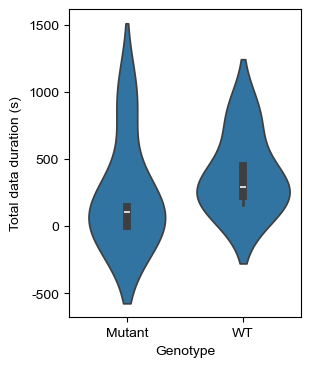

In [42]:
import seaborn as sns
plt.figure(figsize=(3, 4))
sns.violinplot(
    data=df_info, 
    x='Genotype', 
    y='Total data duration (s)'
)

D:\Softwares\anaconda3\envs\rsa32_in_monkeys\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


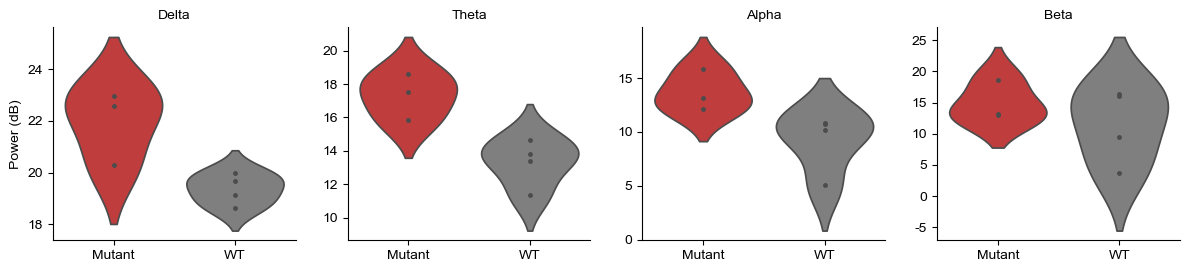

In [80]:
df_plot = df_info.melt(
    value_vars=band_names, 
    value_name='Power (dB)',
    var_name='Band',
    id_vars=['Genotype'],
    ignore_index=False
)

df_plot['Power (dB)'] = 10 * np.log10(df_plot['Power (dB)'])
g = sns.FacetGrid(
    df_plot, 
    col='Band', 
    sharey=False, 
    hue='Genotype', 
    palette=['tab:red', 'tab:gray']
)

g.map_dataframe(
    sns.violinplot,
    data=df_plot, 
    x='Genotype', 
    y='Power (dB)', 
    inner="point"   
)

g.set_titles('{col_name}')
g.set_xlabels('')